# Building FEM solver for the 1D Convection-Diffusion equation (piecewise linear basis functions)
# Table of contents
1. [Introduction](#intro)
2. [Mathematical formulation](#math)
3. [Results](#results)

# Introduction <a name="intro"></a>
## Objective
The purpose of this Jupyter Notebook is to implement a Finite Element Method (FEM) solver step-by-step. This implementation will solidify my theoretical understanding of FEM, allowing me to later use FEM-based industry-standard tools like FEniCS.

This notebook aims to show a full implementation and analysis of the one-dimensional convection-diffusion equation using the Finite Element Method (FEM). Specifically, it focuses on (i) deriving the weak form of the equation and formulating the corresponding finite element problem for different boundary conditions (BCs), (ii) implementing the FEM in Python, (iii) performing numerical experiments to study the solution under various parameter settings (e.g., convection vs. diffusion balance, BCs, mesh size), and comparing the obtained solution with benchmark solutions provided by SciPy.

Adaptive Mesh Refinement and other techniques are not implemented in this notebook. However, they are used and implemented in the modularised code in this repository.


## Problem description

We will solve the one-dimensional convection-diffusion equation with different BCs. This equation describes the transport of a quantity (e.g., heat or pollutants) in a medium where both diffusive and convective processes occur. This is the case for many physical problems, and extensive literature exists describing numerical methods to solve these problems. Consider the steady-state convection-diffusion equation
\begin{equation}
\nabla \cdot \left[- \epsilon\nabla u + \beta u\right] = f,
\end{equation}
where $u$ is the variable of interest (e.g., concentration or temperature), $\epsilon>0$ is the diffusion coefficient, $\beta>0$ is the velocity field of the medium where $u$ is, and $f$ is the source term of $u$. We will consider $\epsilon$ and $\beta$ to be constant over the whole domain. Then, in one spatial dimension the equation becomes 
\begin{align}
-\epsilon \dfrac{\mathrm{d}^2u}{\mathrm{d}x^2} + \beta \dfrac{\mathrm{d}u}{\mathrm{d}x} &= f(x), && x\in(0,1).
\end{align}

The solution to this problem can be difficult for numerical algorithms as a result of the nature of the equation. The relative influence of the dissipative and non-dissipative components (diffusion and convection, respectively) can be characterised by the $\textit{Péclet number}$, defined as $Pe = \dfrac{\beta}{\epsilon}$ for a domain of length 1. For low Péclet numbers, diffusion dominates. Large Péclet numbers indicate convective-dominated problems.

We will take $f(x) = \sin(\pi x)$.

## FEM overview
FEM is a powerful numerical technique for solving PDEs that arise in a wide range of scientific applications. It is useful for the problem under consideration for several reasons:
- Different BCs are easily incorporated in FEM, making it well-suited for real-world problems.
- Scalability and efficiency: the mesh discretisation into smaller elements reduces the computational complexity and scales effectively to larger problems.
- Adaptability: FEM allows for the use of different basis functions, source function, mesh refinement, and other techniques to capture solution features accurately.

Thus, FEM offers a robust method to ensure numerical stability even for high Péclet numbers.

# Mathematical formulation <a name="math"></a>
Let $\Omega:=(0, 1)$ be the domain of the problem and $\overline{\Omega}:=[0,1]$ its closure. The classical solution $u=u(x)$ needs to be sufficiently smooth over the domain, i.e., $u(x) \in C^2(\Omega)\cap C(\overline{\Omega})$.

These requirements can be relaxed by introducing the weak formulation of the problem, which arises after multiplying by a test function and integrating over the domain. The weak solution $u(x)$ (i.e., the function satisfying the weak formulation for all test functions) will be an element of the Sobolev Hilbert space $W_p^k(\Omega)$ with $p=2$ and $k=1$, which will be denoted by $H^1(\Omega)$. We can approximate this infinite-dimensional solution in a finite-dimensional function space $V_h \subset H^1(\Omega)$ if we discretise the domain.

## Domain discretisation and basis functions
We first discretise the domain by dividing $\overline{\Omega}$ into $N$ elements $[x_i, x_{i+1}]$, for $i=0, \dots, N-1$. We also define the spacing $h_i:=x_{i+1}-x_i$. The set of elements and their nodes is called a $\textit{mesh}$.

The required weak solution is approximated by a continuous piecewise linear function in a finite-dimensional function space, which can be expressed as a finite linear combination of basis functions $\phi_i(x)$ defined below.
\begin{equation}
\phi_i(x) =
\begin{cases}
1 - \dfrac{x-x_i}{h_i} & \text{if } x_i \leq x \leq x_{i+1},\\
1 - \dfrac{x_i-x}{h_{i-1}} & \text{if } x_{i-1} \leq x \leq x_{i},\\
0 & \text{else}.
\end{cases}
\end{equation}
Thus, a function in $V_h$ can be expressed as $v(x) = \sum_{i=0}^N V_i\phi_i(x)$.

Note that if the spacing is uniform, then $h:=h_i\,\forall i\in \{0, \dots, N-1\}$ and the basis functions simplify to $\phi_i(x) = \max\left\{1-|\dfrac{x-x_i}{h}|, 0\right\}$.

We can now replace the infinite-dimensional function space of our weak solution $H^1(\Omega)$ with the $(N+1)$-dimensional $V_h:=\mathrm{span}\left\{\phi_0, \dots, \phi_{N}\right\}\subset H^1(\Omega)$.

In [2]:
%matplotlib inline
import numpy as np

class ConvectionDiffusionFEM:
    def __init__(self, N, eps=0.01, beta=1.0, uniform=True, bctype=(0, 0), bcs=(0, 0)):
        '''
        Generate the (uniform or non-uniform) mesh and input parameter values.

        Parameters:
        -----------
        N : int
            number of elements to create. The number of nodes will be N+1.
        eps : float
            diffusion coefficient.
        beta : float
            convection coefficient.
        uniform : bool
            If True, the mesh will contain N elements of uniform size 1 / N. Else, an array of nodes
            uniformly spaced within the domain [0, 1] will be quadratically clustered towards x=1.
        bctype : tuple, optional
            Specifies the left and right type of boundary conditions:
                bctype=0 for Dirichlet BCs.
                bctype=1 for Neumann BCs.
                bctype=2 for Robin BCs.
        bcs: tuple, optional
            Specifies the left and right BCs.
                
        Returns:
        -----------
        ConvectionDiffusionFEM class instance
        '''
        self.N = N
        self.uniform = uniform
        self.eps = eps
        self.beta = beta
        self.bctype = bctype
        self.bcs = bcs

        if self.bctype == (1, 1):
            raise ValueError('Neumann boundary conditions cannot be applied to both boundaries, as the system is left '
                             'underdetermined. Use a Dirichlet condition on at least one boundary.')
        
        if uniform:
            self.x_nodes = np.linspace(0, 1, N+1) # There are N elements and N+1 nodes.
            self.dx = 1 / (len(self.x_nodes) - 1) # dx is the uniform spacing h
        else:
            # Generate uniformly-spaced nodes and cluster them towards x=1 quadratically
            s = np.linspace(0, 1, N+1)
            self.x_nodes = 1 - (1-s)**2
            indices = [i for i in range(len(self.x_nodes))]
            self.node_to_idx = {x: idx for x, idx in zip(self.x_nodes, indices)}
            
            # Create an array of spacings dxs so that dxs[i] = x_nodes[i+1] - x_nodes[i]
            self.dxs = self.x_nodes[1:] - self.x_nodes[:-1]

    def f(self, x):
        return np.sin(np.pi * x)

## Basis functions
Methods can be added to the class in order to compute $\phi_i(x)$ and $\phi_i'(x)$.

In [3]:
def phi(self, x, x_i):
    '''
    Vectorized linear basis function for FEM. Accepts both arrays and floats as inputs

    Parameters:
    -----------
    x : float / ndarray
        Evaluation point / Array with evaluation points.
    x_nodes : ndarray
        Array of all mesh nodes.
    x_i : float
        Node for which the basis function is computed.
    uniform : bool
        Whether the mesh is uniform.

    Returns:
    --------
    phi_values : float / ndarray
        Value / Array with values of the basis function at `x`.
    '''
    if self.uniform:     # Uniform mesh
        dx = 1 / (len(self.x_nodes) - 1)
        return np.maximum(1 - np.abs(x - x_i) / dx, 0)  # Accepts both arrays and floats
    else:           # Non-uniform mesh
        i = int(self.node_to_idx[x_i])

        # Quadrature function 'quad()' passes floats as inputs
        if type(x) == float:
            if x > x_i:
                phi_values = np.maximum(1 - (x - x_i) / self.dxs[i], 0)
            else:
                phi_values = np.maximum(1 - (x_i - x) / self.dxs[i - 1], 0)

        # Array input
        else:
            left_mask = x <= x_i
            right_mask = x > x_i

            phi_values = np.zeros_like(x)
            phi_values[left_mask] = np.maximum(1 - (x_i - x[left_mask]) / self.dxs[i - 1], 0)
            if i < len(self.dxs):
                phi_values[right_mask] = np.maximum(1 - (x[right_mask] - x_i) / self.dxs[i], 0)
        return phi_values


def phi_prime(self, x, x_i):
    '''
    Vectorized derivative of the linear basis function for FEM. Accepts both arrays and floats as inputs

    Parameters:
    -----------
    x : float
        Evaluation point
    x_nodes : ndarray
        Array of all mesh nodes.
    x_i : int
        Node for which the basis function derivative is computed.
    uniform : bool
        Whether the mesh is uniform.

    Returns:
    --------
    gradient : float
        Gradient of the x_i basis functions.
    '''
    if self.uniform:     # Uniform mesh
        dx = 1 / (len(self.x_nodes) - 1)
        if (x_i - dx) <= x <= x_i:
            return 1 / dx  # Slope on the left
        elif x_i < x <= (x_i + dx):
            return -1 / dx  # Slope on the right
        else:
            return 0    # Outside support
    else:           # Non-uniform mesh
        node_idx = int(self.node_to_idx[x_i])
        if self.x_nodes[node_idx - 1] <= x <= x_i:
            dx_left = self.x_nodes[node_idx] - self.x_nodes[node_idx - 1]
            gradient = 1 / dx_left if x_i != 0 else 0
            return gradient
        elif x_i < x <= self.x_nodes[node_idx + 1]:
            dx_right = self.x_nodes[node_idx + 1] - self.x_nodes[node_idx]
            gradient = -1 / dx_right if x_i != 1 else 0
            return gradient
        else:
            return 0


ConvectionDiffusionFEM.phi = phi
ConvectionDiffusionFEM.phi_prime = phi_prime

We can visualise these linear basis functions. If we break down our domain $\Omega = (0,1)$ into 10 elements, then $h=0.1$. Next, we plot the basis function for the central node located at $x=0.5$.

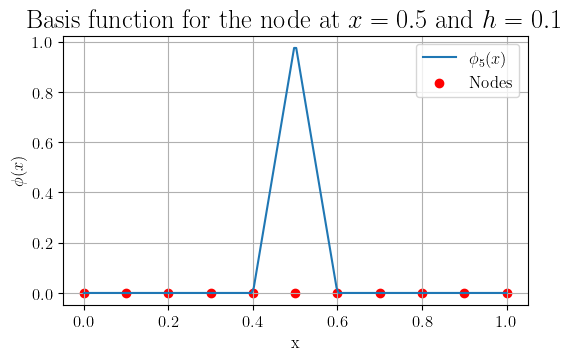

In [4]:
import matplotlib.pyplot as plt

# Plotting settings
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 12})

# Create solver instance and an array of x-values to plot
solver = ConvectionDiffusionFEM(10)
x_phi = np.linspace(0, 1, 200)

# Plot
plt.figure(figsize=(6,3.5))
plt.plot(x_phi, solver.phi(x_phi, 0.5), label=r'$\phi_5(x)$')
plt.scatter(np.linspace(0, 1, 11), np.zeros(len(np.linspace(0, 1, 11))), color='red', label='Nodes')
plt.title(r'Basis function for the node at $x=0.5$ and $h=0.1$', fontsize=19)
plt.xlabel('x')
plt.ylabel(r'$\phi(x)$')
plt.grid(True)
plt.legend()
plt.show()

## Weak formulation and FEM approximation

The weak formulation obtained depends on the type of boundary conditions. Dirichlet BCs specify the value of the solution at the boundary. For example, in a heat conduction problem, a Dirichlet BC could set the temperature at a boundary to a fixed value. Neumann BCs specify the flux of the solution at the boundary, corresponding to the derivative of the solution normal to the surface. In the heat conduction example, this could represent a prescribed heat flux across the boundary, such as the rate of heat transfer due to external sources or insulation. 

### Homogeneous Dirichlet BCs
The whole problem together with the BCs is given by
\begin{align}
-\epsilon \dfrac{\mathrm{d}^2u}{\mathrm{d}x^2} + \beta \dfrac{\mathrm{d}u}{\mathrm{d}x} &= f(x), && x\in(0,1),\\
u &= 0, && \text{for } x = 0, 1,
\end{align}
Consider $H_0^1(\Omega)$, the subspace of $H^1(\Omega)$ containing functions $v$ such that $v=0$ on the boundary $\partial\Omega$. Multiplying the original problem times a test function $v\in H_0^1(\Omega)$, integrating over the domain, and using integration by parts on the first term gives the weak formulation of the problem.
\begin{align}
\epsilon\int_0^1 \dfrac{\mathrm{d}u}{\mathrm{d}x}\dfrac{\mathrm{d}v}{\mathrm{d}x}\mathrm{d}x + \beta\int_0^1 \dfrac{\mathrm{d}u}{\mathrm{d}x}v\mathrm{d}x &= \int_0^1 fv\mathrm{d}x, && x \in \Omega,\\
u&=0, && x \in \partial\Omega.
\end{align}
The boundary terms arising from integration by parts disappear due to the BCs. The weak solution is the function $u\in H_0^1(\Omega)$ that makes the weak problem above true for all functions $v\in H_0^1(\Omega)$.

### Inhomogeneous Dirichlet BCs
The inhomogeneous Dirichlet problem is given by
\begin{align}
-\epsilon \dfrac{\mathrm{d}^2u}{\mathrm{d}x^2} + \beta \dfrac{\mathrm{d}u}{\mathrm{d}x} &= f(x), && x\in(0,1),\\
u(0) &= g_0,\\u(1) &= g_1.
\end{align}

We let $u(x) = u_h(x) + u_g(x)$, where $u_h(x)$ is a function satisfying homogeneous BCs as in the previous subsection, and $u_g(x)$ is a function explicitly chosen to satisfy the inhomogeneous BCs, $u(0) = g_0$ and $u(1)=g_1$. For example, we can linearly interpolate the BCs by letting $u_g(x) = g_0 + (g_1 - g_0) x$. This way, BCs are automatically satisfied by $u_g$, leaving $u_h$ to be determined with bounday constraints. Substituting $u = u_h + u_g$ we can isolate $u_h$ and solve for it using FEM.

\begin{align}
&\epsilon\int_0^1 \dfrac{\mathrm{d}u}{\mathrm{d}x}\dfrac{\mathrm{d}v}{\mathrm{d}x}\mathrm{d}x + \beta\int_0^1 \dfrac{\mathrm{d}u}{\mathrm{d}x}v\mathrm{d}x = \int_0^1 fv\mathrm{d}x,\\
&\epsilon\int_0^1 \dfrac{\mathrm{d}}{\mathrm{d}x}(u_h + u_g)\dfrac{\mathrm{d}v}{\mathrm{d}x}\mathrm{d}x + \beta\int_0^1 \dfrac{\mathrm{d}}{\mathrm{d}x}(u_h + u_g)v\mathrm{d}x = \int_0^1 fv\mathrm{d}x,\\
&\epsilon\int_0^1 \dfrac{\mathrm{d}u_h}{\mathrm{d}x}\dfrac{\mathrm{d}v}{\mathrm{d}x}\mathrm{d}x + \beta\int_0^1 \dfrac{\mathrm{d}u_h}{\mathrm{d}x}v\mathrm{d}x = \int_0^1 \left[fv - \epsilon\dfrac{\mathrm{d}u_g}{\mathrm{d}x}\dfrac{\mathrm{d}v}{\mathrm{d}x} - \beta \dfrac{\mathrm{d}u_g}{\mathrm{d}x}v \right]\mathrm{d}x, && \forall v \in H_0^1(\Omega).\\
\end{align}
The weak solution is the function $u = u_h + u_g \in H^1(\Omega)$ that makes the weak problem true for all functions $v\in H_0^1(\Omega)$.

### Neumann BCs
Neumann BCs specify the values of the derivative applied at the boundary of the domain. The mathematical problem is given by
\begin{align}
-\epsilon \dfrac{\mathrm{d}^2u}{\mathrm{d}x^2} + \beta \dfrac{\mathrm{d}u}{\mathrm{d}x} &= f(x), && x\in(0,1),\\
\dfrac{\mathrm{d}u}{\mathrm{d}x}(0) &= q_0,\\\dfrac{\mathrm{d}u}{\mathrm{d}x}(1) &= q_1.
\end{align}

In this case, the boundary term arising from integration by parts does not vanish, given that now we do not require $v=0$ on $\partial\Omega$. We have
\begin{align}
&\epsilon\int_0^1 \dfrac{\mathrm{d}u}{\mathrm{d}x}\dfrac{\mathrm{d}v}{\mathrm{d}x}\mathrm{d}x + \beta\int_0^1 \dfrac{\mathrm{d}u}{\mathrm{d}x}v\mathrm{d}x = \int_0^1 fv\mathrm{d}x + q_1v(1) - q_0v(0), && \forall v \in H^1(\Omega).
\end{align}
The weak solution is the function $u\in H^1(\Omega)$ that makes the weak problem true for all functions $v\in H^1(\Omega)$.

### Mixed BCs
We also consider the mixed case. Consider a Dirichlet condition at the left boundary $x=0$ and a Neumann condition at the right boundary $x=1$. The differential equation is now
\begin{align}
-\epsilon \dfrac{\mathrm{d}^2u}{\mathrm{d}x^2} + \beta \dfrac{\mathrm{d}u}{\mathrm{d}x} &= f(x), && x\in(0,1),\\
u(0) &= g_0,\\\dfrac{\mathrm{d}u}{\mathrm{d}x}(1) &= q_1.
\end{align}

Now only the right boundary has a contribution in the RHS of the resulting linear system, as it is not fixed by the Neumann condition. The left boundary is still fixed, as in the case of inhomogeneous Dirichlet BCs, so we can reduce our function space to $H_{0, 0}^1(\Omega) = \left\{v \in H^1(\Omega): v=0 \text{ on } x=0\right\}$.
\begin{align}
&\epsilon\int_0^1 \dfrac{\mathrm{d}u}{\mathrm{d}x}\dfrac{\mathrm{d}v}{\mathrm{d}x}\mathrm{d}x + \beta\int_0^1 \dfrac{\mathrm{d}u}{\mathrm{d}x}v\mathrm{d}x = \int_0^1 fv\mathrm{d}x + q_1v(1), && \forall v \in H_{0, 0}^1(\Omega).\\
\end{align}

To account for the Dirichlet condition at the left boundary, we do as before and let $u=u_h + u_g$ where $u_h(x)$ solves the problem with homogeneous conditions, that is
\begin{align}
u_h(0) &= 0, && \dfrac{\mathrm{d}u_h}{\mathrm{d}x}(1) = q_1 - \dfrac{\mathrm{d}u_g}{\mathrm{d}x}(1),
\end{align}
and $u_g(x)$ satisfies the inhomogeneous boundary conditions, i.e.,
\begin{align}
u_g(0) &= g_0, && \dfrac{\mathrm{d}u_g}{\mathrm{d}x}(1) = q_1.
\end{align}

We set $u_g(x) = Ax + B$ to be linear, and find the required values $A$ and $B$. Note $u_g(0) = B = g_0$ and $\dfrac{\mathrm{d}u_g}{\mathrm{d}x}(1) = A = q_1$. Hence the inhomogeneous part of the solution is $u_g(x) = q_1x + g_0$.

Then
\begin{align}
&\epsilon\int_0^1 \dfrac{\mathrm{d}}{\mathrm{d}x}(u_h + u_g)\dfrac{\mathrm{d}v}{\mathrm{d}x}\mathrm{d}x + \beta\int_0^1 \dfrac{\mathrm{d}}{\mathrm{d}x}(u_h + u_g)v\mathrm{d}x = \int_0^1 fv\mathrm{d}x + q_1v(1),\\
&\epsilon\int_0^1 \dfrac{\mathrm{d}u_h}{\mathrm{d}x}\dfrac{\mathrm{d}v}{\mathrm{d}x}\mathrm{d}x + \beta\int_0^1 \dfrac{\mathrm{d}u_h}{\mathrm{d}x}v\mathrm{d}x = \int_0^1 \left[fv - \epsilon\dfrac{\mathrm{d}u_g}{\mathrm{d}x}\dfrac{\mathrm{d}v}{\mathrm{d}x} - \beta \dfrac{\mathrm{d}u_g}{\mathrm{d}x}v \right]\mathrm{d}x + q_1v(1), && \forall v \in H_{0, 0}^1(\Omega).\\
\end{align}

The calculation, similar for the opposite case where the left boundary has a Neumann condition and the right boundary a Dirichlet condition, yields a similar expression where instead of the last term being $q_1v(1)$, it is $-q_0v(0)$.

The different weak formulations derived here form the basis for assembling the element stiffness matrix and load vector in the FEM implementation.

## FEM approximation
The weak formulation arrived at earlier is
\begin{align}
&\epsilon\int_0^1 \dfrac{\mathrm{d}u_h}{\mathrm{d}x}\dfrac{\mathrm{d}v}{\mathrm{d}x}\mathrm{d}x + \beta\int_0^1 \dfrac{\mathrm{d}u_h}{\mathrm{d}x}v\mathrm{d}x = \int_0^1 \left[fv - \epsilon\dfrac{\mathrm{d}u_g}{\mathrm{d}x}\dfrac{\mathrm{d}v}{\mathrm{d}x} - \beta \dfrac{\mathrm{d}u_g}{\mathrm{d}x}v \right]\mathrm{d}x, && \forall v \in H_0^1(\Omega),\\
\end{align}
where $u_g(x)$ interpolates the given BCs. Importantly, if some boundary has a Neumann BC, then the corresponding term is added to the RHS ($-q_0v(0)$ for the left boundary, $+q_1v(1)$ for the right boundary).

We can approximate our solution from $H^1(\Omega)$ in our finite-dimensional space by
\begin{equation}
u_h(x) \approx \sum_{i=0}^N U_{h, i}\phi_i(x).
\end{equation}
Note that, if $u_h \in H_0^1(\Omega)$ instead of $u_h\in H^1(\Omega)$, then $U_{h, 0}=U_{h, N}=0$. Similarly, if $u_h\in H_{0, 0}^1(\Omega)$, then $U_{h, 0}=0$, and if $u_h\in H_{0, 1}^1(\Omega)$, then $U_{h, N}=0$.

Then our FEM approximation of the weak problem is to find $U=(U_0, \dots, U_N)^T\in\mathbb{R}^{N+1}$ such that
\begin{align}
\sum_{i=0}^NU_{h, i}\int_0^1 \left[\epsilon\dfrac{\mathrm{d}\phi_i}{\mathrm{d}x}\dfrac{\mathrm{d}\phi_j}{\mathrm{d}x} + \beta\dfrac{\mathrm{d}\phi_i}{\mathrm{d}x}\phi_j\right]\mathrm{d}x &= \int_0^1 \left[f\phi_j - \epsilon\dfrac{\mathrm{d}u_g}{\mathrm{d}x}\dfrac{\mathrm{d}\phi_j}{\mathrm{d}x} - \beta \dfrac{\mathrm{d}u_g}{\mathrm{d}x}\phi_j \right]\mathrm{d}x, && j=0, \dots, N.\\
\end{align}

Notice how in the finite-dimensional subspace, the weak solution is the function satisfying the above expression for all integer values of $j$ between $0$ and $N$, which is equivalent to the previous weak formulation being satisfied for all test functions $v$.

### Homogeneous Dirichlet BCs
If both boundaries have homogeneous Dirichlet BCs, then $u_g(x) = u_g'(x)=0$. Therefore, the weak formulation can be approximated by the following statement: find $U_i=(U_1,\dots,U_{N-1})^T\in\mathbb{R}^{N-1}$ such that:
\begin{align}
\sum_{i=1}^{N-1}U_i\int_0^1 \left(\epsilon\phi_i'(x)\phi_j'(x) + \beta\phi_i'(x)\phi_j(x)\right)\mathrm{d}x &= \int_0^1 f(x)\phi_j(x)\mathrm{d}x, && j=1,\dots,N-1,\\
U_0 = U_N &= 0.
\end{align}

This can be written as a matrix problem:
\begin{equation}
AU=F,
\end{equation}
where $A\in\mathbb{R}^{(N-1)\times(N-1)}$, and $F, U \in \mathbb{R}^{N-1}$. The $[i,j]$ entrix of $A$ is given by $A_{ij} = \int_0^1 \left(\epsilon\phi_j'(x)\phi_i'(x) + \beta\phi_j'(x)\phi_i(x)\right)\mathrm{d}x$ and $F_i = \int_0^1 \sin(\pi x) \phi_i(x)\mathrm{d}x$.

These will be computed exactly if the mesh is uniform. For the non-uniform case, we will use quadrature aproximations for the integrals implemented in the Scipy library.

### Inhomogeneous Dirichlet BCs

We had
\begin{align}
\sum_{i=0}^NU_{h, i}\int_0^1 \left[\epsilon\dfrac{\mathrm{d}\phi_i}{\mathrm{d}x}\dfrac{\mathrm{d}\phi_j}{\mathrm{d}x} + \beta\dfrac{\mathrm{d}\phi_i}{\mathrm{d}x}\phi_j\right]\mathrm{d}x &= \int_0^1 \left[f\phi_j - \epsilon\dfrac{\mathrm{d}u_g}{\mathrm{d}x}\dfrac{\mathrm{d}\phi_j}{\mathrm{d}x} - \beta \dfrac{\mathrm{d}u_g}{\mathrm{d}x}\phi_j \right]\mathrm{d}x, && j=0, \dots, N.\\
\end{align}
However for Dirichlet BCs, we can fix $U_{h, 0} = U_{h, N} = 0$ given that the values $U_{h, i}$ are the coefficients of the finite-dimensional approximation of the function $u_h(x)$, which satisfies homogeneous BCs. Recall that the inhomogeneous values are accounted for by $u_g(x)$ at a later stage, when reconstructing $u(x) = u_h(x) + u_g(x)$. Hence
\begin{align}
\sum_{i=1}^{N-1}U_{h, i}\int_0^1 \left[\epsilon\dfrac{\mathrm{d}\phi_i}{\mathrm{d}x}\dfrac{\mathrm{d}\phi_j}{\mathrm{d}x} + \beta\dfrac{\mathrm{d}\phi_i}{\mathrm{d}x}\phi_j\right]\mathrm{d}x &= \int_0^1 \left[f\phi_j - \epsilon\dfrac{\mathrm{d}u_g}{\mathrm{d}x}\dfrac{\mathrm{d}\phi_j}{\mathrm{d}x} - \beta \dfrac{\mathrm{d}u_g}{\mathrm{d}x}\phi_j \right]\mathrm{d}x, && j=1, \dots, N-1,\\
\end{align}
which can be re-expressed similarly as before as a matrix system $AU=F$. Likewise, $A\in\mathbb{R}^{(N-1)\times(N-1)}$, and $F, U \in \mathbb{R}^{N-1}$.

Note that the stiffness matrix is equal to the one for the homogeneous Dirichlet BCs. Furthermore, the entries of the load vector from the homogeneous case arise too from this expression, given that $\dfrac{\mathrm{d}u_g}{\mathrm{d}x} = 0$ for the homogeneous case where $g_0=g_1=0$. Therefore, all Dirichlet BCs can be computed with the same code.

### Mixed BCs
Consider a Dirichlet condition at the left boundary and a Neumann condition at the right. Here, $U_{h, 0} = 0$ but the value of $U_{h, N}$ is not set, so the linear system also has an equation for $j=N$. If the BC types were reversed, then the system would include an equation for $j=0$.

Observe that $v(1) = \sum_{i=0}^N V_i\phi_i(1) = V_N\phi_N(1) = V_N$. Thus, our FEM approximation is now
\begin{align}
\sum_{i=1}^{N}U_{h, i}\int_0^1 \left[\epsilon\dfrac{\mathrm{d}\phi_i}{\mathrm{d}x}\dfrac{\mathrm{d}\phi_j}{\mathrm{d}x} + \beta\dfrac{\mathrm{d}\phi_i}{\mathrm{d}x}\phi_j\right]\mathrm{d}x &= \int_0^1 \left[f\phi_j - \epsilon\dfrac{\mathrm{d}u_g}{\mathrm{d}x}\dfrac{\mathrm{d}\phi_j}{\mathrm{d}x} - \beta \dfrac{\mathrm{d}u_g}{\mathrm{d}x}\phi_j \right]\mathrm{d}x + \epsilon q_1\phi_N(1), && j=1, \dots, N.\\
\end{align}
Only the last entry of the load vector $F_N$ is affected by the $\epsilon q_1$ term. Here, $A\in\mathbb{R}^{N\times N}$ and $F, U\in\mathbb{R}^N$.

If the BC types were reversed, then only the first term $F_0$ would be affected by $-\epsilon q_0$, and $F_N$ would not need to be computed as then $U_{h, N} = 0$.

In order to implement this, we will compute the whole $(N+1)\times(N+1)$ stiffness matrix and the $N+1$ load vector. Then, the rows/columns/elements corresponding to the Dirichlet-type boundary will be removed.

### Computation of vector F for uniform mesh, $f(x) = \sin(\pi x)$, and homogeneous Dirichlet BCs
For the uniform mesh with spacing $h$ and for the source function $f(x)=\sin(\pi x)$, we can find $F_j$ analytically.
\begin{align}
F_j &= \int_{x_{j-1}}^{x_{j+1}}\sin(\pi x) \left(1 - \left|\dfrac{x - x_j}{h}\right|\right)\mathrm{d}x\\
&= \int_{x_{j-1}}^{x_{j}}\sin(\pi x) \left(1 + \dfrac{x - x_j}{h}\right)\mathrm{d}x + \int_{x_{j}}^{x_{j+1}}\sin(\pi x) \left(1 - \dfrac{x - x_j}{h}\right)\mathrm{d}x.
\end{align}

Using integration by parts twice results, after some algebra, in the following expression:
\begin{align}
F_j &= \dfrac{1}{\pi}\left[\cos(\pi x_{j-1}) - \cos(\pi x_{j+1}) - \dfrac{x_j}{h}\left(\cos(\pi x_{j+1}) + \cos(\pi x_{j-1})\right)\right.\\
&- \left.\dfrac{1}{h\pi}\left(\sin(\pi x_{j+1}) - 2\sin(\pi x_j) + \sin(\pi x_{j-1})\right) + \dfrac{1}{h}\left(x_{j+1}\cos(\pi x_{j+1}) + x_{j-1}\cos(\pi x_{j-1})\right)\right]
\end{align}

In [5]:
def build_rhs_uniform(self):
    '''
    Assemble vector F exactly for uniform meshes and homogeneous BCs.
    Its i-th element is the integral from x_{i-1} to x_{i+1} of sin(pi*x)*phi_i(x).
    
    Returns:
    -----------
    Vector F as ndarray of N+1 elements
    '''
    x_nodes = self.x_nodes
    dx = self.dx
    F = []

    # Vectorised computation of F
    for i, x in enumerate(x_nodes):
        if i == 0 or i == len(x_nodes) - 1:
            continue
        term_1 = np.cos(np.pi * x_nodes[i - 1]) - np.cos(np.pi * x_nodes[i + 1])
        term_2 = - (x / dx) * (np.cos(np.pi * x_nodes[i + 1]) + np.cos(np.pi * x_nodes[i - 1]))
        term_3 = - (1 / (dx * np.pi)) * (np.sin(np.pi * x_nodes[i + 1])
                                         - 2 * np.sin(np.pi * x)
                                         + np.sin(np.pi * x_nodes[i - 1]))
        term_4 = (1 / dx) * (x_nodes[i + 1] * np.cos(np.pi * x_nodes[i + 1])
                             + x_nodes[i - 1] * np.cos(np.pi * x_nodes[i - 1]))
        l = (term_1 + term_2 + term_3 + term_4) / np.pi
        F.append(l)

    F = np.concatenate(([0], F, [0]))
    return np.array(F)


ConvectionDiffusionFEM.build_rhs_uniform = build_rhs_uniform

### Computation of vector F for generic non-uniform mesh, accepting mixed BCs
Recall $F_i = \int_0^1 \sin(\pi x) \phi_i(x)\mathrm{d}x$.

In [6]:
from scipy.integrate import quad


def BCs(self):
    '''
    Constructs interpolation functions for boundary conditions.

    This function generates a function 'u_g(x)' and its derivative 'u_g_prime(x)'
    to interpolate or construct boundary conditions based on the specified types.
    It supports mixed Dirichlet and Neumann boundary conditions in 1D problems.

    Returns:
    ----------
    u_g : function
        A lambda function that interpolates or constructs the solution
        satisfying the specified boundary conditions.
    u_g_prime : function
        A lambda function representing the derivative of 'u_g(x)'.

    Raises:
    ----------
    ValueError
        If 'self.bctype' is not one of (0, 0), (0, 1), or (1, 0).
    '''

    g0 = self.bcs[0]  # Boundary value or flux at the left boundary (x = 0).
    g1 = self.bcs[1]  # Boundary value or flux at the right boundary (x = 1).
    
    if self.bctype == (0, 0):
        u_g = lambda x: g0 + (g1 - g0) * x
        u_g_prime = lambda x: g1 - g0
    elif self.bctype == (0, 1):
        u_g = lambda x: g0 + g1 * x
        u_g_prime = lambda x: g1
    elif self.bctype == (1, 0):
        u_g = lambda x: g1 - g0 + g0 * x
        u_g_prime = lambda x: g0
    else:
        raise ValueError("Only (0, 0), (0, 1), (1, 0) are valid values for the argument bctype.")
    return u_g, u_g_prime


def build_rhs(self):
    '''
    Assemble the right-hand side (RHS) vector for a 1D finite element convection-diffusion problem.

    This function computes the RHS vector for the linear system arising from the weak fromulation
    of a 1D PDE. The computation incorporates the source term, boundary conditions, and the basis
    functions used in the finite element method.
    
    Returns:
    -------
    F : ndarray of shape (len(self.x_nodes),)
        The assembled RHS vector. Each entry corresponds to the contribution of the
        respective basis function.

    Notes:
    -----
    - The function uses numerical integration (via 'scipy.integrate.quad') to compute
    element contributions to the RHS vector.
    - Dirichlet boundary conditions are incorporated into the formulation through the
    'BCs_1d' function, which provides 'u_g' and 'u_g_prime'.
    - Neumann boundary conditions directly modify the entries of the RHS vector.
    '''
    # Initialise the RHS vector with zeros
    F = np.zeros(len(self.x_nodes))

    # Extract the boundary values (if Dirichlet) or derivative values (if Neumann)
    g0, g1 = self.bcs[0], self.bcs[1]

    # Compute interpolated boundary functions u_g(x) and u_g_prime(x)
    u_g, u_g_prime = self.BCs()

    # Loop over nodes to compute the contribution of each basis function
    for i, x_i in enumerate(self.x_nodes):
        # Determine the integration limits for the current node
        left = self.x_nodes[np.maximum(i-1, 0)]
        right = self.x_nodes[np.minimum(i+1, len(self.x_nodes) - 1)]

        # Integrate contributions from source term, diffusion, and convection
        F[i], _ = quad(
            lambda x: self.f(x) * self.phi(x, x_i) -
            self.eps * u_g_prime(x) * self.phi_prime(x, x_i) -
            self.beta * u_g_prime(x) * self.phi(x, x_i),
            left,
            right
        )

    # Apply modifications for Neumann boundary conditions, if present
    if self.bctype == (0, 1):
        F[-1] += self.eps * g1
    elif self.bctype == (1, 0):
        F[0] -= self.eps * g0

    # Return the assembled RHS vector with N+1 entries
    return F


ConvectionDiffusionFEM.BCs = BCs
ConvectionDiffusionFEM.build_rhs = build_rhs

### Computation of stiffness matrix A for uniform mesh
For a uniform mesh, the entries of the matrix can be computed exactly. Specifically, A is a tridiagonal matrix of the form
\begin{equation}A = 
\begin{pmatrix}
\frac{2}{h}\left(\epsilon + \frac{\beta}{4}\left(x_0 - 2x_1 + x_2\right)\right) & -\frac{\epsilon}{h} + \frac{\beta}{2} & 0 & \cdots & 0\\
-\frac{\epsilon}{h} - \frac{\beta}{2} & \frac{2}{h}\left(\epsilon + \frac{\beta}{4}\left(x_1 - 2x_2 + x_3\right)\right) & -\frac{\epsilon}{h} + \frac{\beta}{2} & \cdots & 0\\
0 & -\frac{\epsilon}{h} - \frac{\beta}{2} & \frac{2}{h}\left(\epsilon + \frac{\beta}{4}\left(x_2 - 2x_3 + x_4\right)\right) & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & \frac{2}{h}\left(\epsilon + \frac{\beta}{4}\left(x_{N-2} - 2x_{N-1} + x_N\right)\right)
\end{pmatrix}
\end{equation}

### Computation of stiffness matrix A for non-uniform mesh, all BCs
Recall $A_{ij} = \int_0^1 \left(\epsilon\phi_j'(x)\phi_i'(x) + \beta\phi_j'(x)\phi_i(x)\right)\mathrm{d}x$.

In [7]:
def build_stiffness_matrix(self):
    if self.uniform:
        '''
        Assemble the tridiagonal matrix in banded form.

        Returns:
        -----------
        A: ndarray
            Tridiagonal stiffness matrix in banded form to avoid storing many 0 values.
        '''
        N = self.N
        eps, beta = self.eps, self.beta
        dx = self.dx  # Uniform spacing h
        x_nodes = self.x_nodes

        # Main, upper, and lower diagonals
        main_diag = (2 / dx) * (eps + (beta / 4) * (x_nodes[2:] - 2 * x_nodes[1:-1] + x_nodes[:-2]))
        upper_diag = (-(eps / dx) + (beta / 2)) * np.ones(N - 2)
        lower_diag = (-(eps / dx) - (beta / 2)) * np.ones(N - 2)

        # Use banded format
        A = np.zeros((3, len(main_diag)))
        A[0, 1:] = upper_diag
        A[1, :] = main_diag
        A[2, :-1] = lower_diag

        return A

    else:
        '''
        Assemble the stiffness matrix for a 1D finite element method on a non-uniform mesh applied
        to the convection-diffusion equation.
    
        This function computes the global stiffness matrix for a 1D convection-diffusion problem using
        linear finite elements. The stiffness matrix is assembled from contributions of the element-wise
        stiffness matrices, which are calculated using the given basis functions and their gradients.
    
        Returns:
        -------
        A : ndarray of shape (N+1, N+1)
            The assembled global stiffness matrix, where 'N' is the number of elements (equal to
            'len(self.x_nodes) - 1'). Each entry corresponds to the integral of weighted products of basis
            functions and their gradients over the elements.
    
        Notes:
        -----
        The stiffness matrix is computed using numerical integration (via `scipy.integrate.quad`)
        over each element, which accounts for potentially non-uniform spacing between nodes.
        '''
        N = len(self.x_nodes) - 1   # Number of elements
        A = np.zeros((N+1, N+1))    # Initialise the global stiffness matrix
    
        # Loop over each element
        for e in range(len(self.x_nodes) - 1):
            # Define the boundaries of the current element
            x_left, x_right = self.x_nodes[e], self.x_nodes[e + 1]
    
            # Initialise the element stiffness matrix for the current element
            K_e = np.zeros((2, 2))  # 2x2 for linear basis functions (two nodes per element)
    
            # Loop over local basis functions (i: row, j: column in K_e)
            for i in range(2):  # Local basis function i (0: left node, 1: right node)
                for j in range(2):  # Local basis function j (0: left node, 1: right node)
                    # Define the nodes associated with basis functions i and j
                    x_i = self.x_nodes[e + i]
                    x_j = self.x_nodes[e + j]
    
                    # Compute the gradient term (diffusion contribution)
                    grad_integrand = lambda x: (self.eps * self.phi_prime(x, x_i) *
                                                self.phi_prime(x, x_j))
                    grad_contribution, _ = quad(grad_integrand, x_left, x_right)
    
                    # Compute the mixed term (convection contribution)
                    mixed_integrand = lambda x: (self.beta * self.phi_prime(x, x_i) *
                                                 self.phi(x, x_j))
                    mixed_contribution, _ = quad(mixed_integrand, x_left, x_right)
    
                    # Sum contributions to form the local stiffness matrix entry
                    K_e[j, i] = grad_contribution + mixed_contribution
    
            # Assemble the local stiffness matrix K_e into the global stiffness matrix A
            A[e:e + 2, e:e + 2] += K_e
    
        return A

ConvectionDiffusionFEM.build_stiffness_matrix = build_stiffness_matrix

## FEM solution
Let's now implement the matrix system $AU = F$ to find our vector of unknowns $U_i$, for $1\leq i\leq N-1$

In [8]:
from scipy.linalg import solve_banded, solve

def solve_fem(self, x_eval):
    '''
    Solve the FEM system and return the solution at evaluation points.

    Parameters:
    -----------
    x_eval : ndarray
        Array of x values on which the solution will be evaluated.

    Returns:
    -----------
    u_eval : ndarray
        Array with the same length as x_eval storing the value of the solution u(x) for every
        x in x_eval.
    '''
    # Compute matrix A
    A = self.build_stiffness_matrix()
    
    # Compute vector F
    if self.uniform:
        #print('Warning: the function used to exactly assemble the RHS vector F assumes homogeneous Dirichlet BCs.')
        F = self.build_rhs_uniform()
        F = F[1:-1]  # Exclude F_0 and F_N
        U = solve_banded((1, 1), A, F)
        U_h = np.concatenate(([0], U, [0])) # Add boundary values
    else:
        F = self.build_rhs()
        if self.bctype == (0, 0):
            F = F[1:-1]
            A = A[1:-1, 1:-1]
        elif self.bctype == (1, 0):
            F = F[:-1]
            A = A[:-1, :-1]
        elif self.bctype == (0, 1):
            F = F[1:]
            A = A[1:, 1:]
        
        # Compute coefficients
        U = solve(A, F)
        # Add homogeneous Dirichlet boundary values
        if self.bctype == (0, 0):
            U_h = np.concatenate(([0], U, [0]))
        elif self.bctype == (1, 0):
            U_h = np.concatenate((U, [0]))
        elif self.bctype == (0, 1):
            U_h = np.concatenate(([0], U))        

    # Evaluate the solution u_h(x) at the evaluation points
    u_h = np.array([sum(U_i * self.phi(x, x_i) for U_i, x_i in zip(U_h, self.x_nodes)) for x in x_eval])

    # Compute the inhomogeneous part u_g(x) at the evaluation points
    u_g_function, _ = self.BCs()
    u_g = u_g_function(x_eval)
    return u_h + u_g

ConvectionDiffusionFEM.solve_fem = solve_fem

# Results <a name="results"></a>
We can finally evaluate the solution against the solution given by SciPy's solve_bvp() function and compute the $L_2$- and the $H^1$-associated norm of the error.

In [10]:
from scipy.integrate import solve_bvp, simpson
from scipy.interpolate import interp1d

def solve_scipy(self, x_eval):
    '''
    Solve the same problem using SciPy's solve_bvp for comparison. Accounts
    for Dirichlet, Neumann, and mixed boundary conditions.

    Parameters:
    ----------
    x_eval : ndarray
        Values of x for which the solution will be computed.

    Returns:
    -------
    sol.x : ndarray
        Values of x on which the solution is approximated.
    sol.y[0] : ndarray
        Values of u(x) obtained with solve_bvp().
    '''

    g0, g1 = self.bcs[0], self.bcs[1]

    # Define ODE and specify its boundary conditions (BC)
    def ode_system(x, y):
        '''
        Defines the ODE system:
        y[0] = u(x) is the solution.
        y[1] = u'(x) is the solution derivative.
        '''
        return np.vstack((y[1], (self.beta * y[1] - np.sin(np.pi * x)) / self.eps))
    def bc(ya, yb):
        '''
        Specifies boundary conditions based on self.bctype.
        - (0, 0): Dirichlet at both boundaries.
        - (0, 1): Dirichlet at the left boundary, Neumann at the right.
        - (1, 0): Neumann at the left boundary, Dirichlet at the right.
        '''
        if self.bctype == (0, 0):
            return np.array([ya[0] - g0, yb[0] - g1])
        elif self.bctype == (0, 1):
            return np.array([ya[0] - g0, yb[1] - g1])
        elif self.bctype == (1, 0):
            return np.array([ya[1] - g0, yb[0] - g1])

    # Apply solve_bvp to the same mesh
    x = self.x_nodes
    y_initial = np.zeros((2, x.size))
    sol = solve_bvp(ode_system, bc, x, y_initial)

    # Evaluate at points in x_eval
    u_eval = sol.sol(x_eval)[0]
    return u_eval

def obtain_l2_error(self, x_eval, u_fem, u_bvp):
    '''
    Compute the L2-norm of the error between the FEM solution and SciPy's solution.

    Parameters:
    -----------
    x_eval : ndarray
        x-values for the FEM solution.
    u_fem : ndarray
        FEM solution u_fem(x). Array with length equal to len(x_eval).
    u_bvp : ndarray
        SciPy's solution u_bvp(x). Array with length equal to len(x_eval).

    Returns:
    -----------
    l2_error : float
        L2-norm of the error u_fem(x) - u_bvp(x).
    '''
    # Compute the error
    l2_error = np.sqrt(simpson((u_fem - u_bvp) ** 2, x=x_eval))
    return l2_error

def obtain_h1_error(self, x_eval, u_fem, u_bvp):
    '''
    Compute the H1-norm of the error between the FEM solution and SciPy's solve_bvp solution.

    The H1-norm accounts for both the L2-norm of the error and the discrepancy in the gradients
    between the FEM and SciPy solutions. This provides a comprehensive measure of the solution's
    accuracy in the Sobolev space H1.

    Parameters:
    -----------
    x_eval : ndarray
        Array of x-coordinates where the FEM solution is evaluated.
    u_fem : ndarray
        Array of FEM solution values corresponding to x_eval.
    u_bvp : ndarray
        Array of SciPy's solve_bvp solution values corresponding to x_bvp.

    Returns:
    -----------
    h1_error : float
        H1-norm of the error u_fem(x) - u_bvp(x).
    '''
    
    # Compute gradients
    grad_fem = np.gradient(u_fem, x_eval)
    grad_bvp = np.gradient(u_bvp, x_eval)

    # Compute L2 norm and H1 semi-norm
    l2_error = self.obtain_l2_error(x_eval, u_fem, u_bvp)
    h1_semi_error = np.sqrt(simpson((grad_fem - grad_bvp) ** 2, x=x_eval))

    # Combine into H1 norm
    h1_error = np.sqrt(l2_error ** 2 + h1_semi_error ** 2)
    return h1_error

def compare_solution(self, N_eval=200, plot=True, error=False):
    '''
    Compare the FEM solution with SciPy's solve_bvp solution.
    
    This method evaluates the FEM solution at a specified number of points, computes the
    L2- and H1-norms of the error relative to SciPy's solution, and optionally plots both 
    solutions. The nodes of the FEM solution are also highlighted in the plot.

    Parameters:
    -----------
    N_eval : int, optional
        Number of points at which the FEM solution is evaluated. Default is 200.
    plot : bool, optional
        If True, prints the L2- and H1-norms of the error and generates a comparison plot.
        Default is True.
    error : bool, optional
        If True, returns the computed L2- and H1-norms of the error as floats. Default is
        False.

    Returns:
    -----------
    None
        If 'error' is False, the method does not return anything.
    tuple of floats
        If 'error' is True, returns a tuple containing:
        - L2-norm of the error (float)
        - H1-norm of the error (float)    
    '''
    # Solve using FEM
    x_eval = np.linspace(0, 1, N_eval)
    u_fem = self.solve_fem(x_eval)

    # Solve using solve_bvp
    u_bvp = self.solve_scipy(x_eval)

    # Plot
    if plot:
        # Print H1-error
        print('L2-norm of the error:', self.obtain_l2_error(x_eval, u_fem, u_bvp))
        print('H1-norm of the error:', self.obtain_h1_error(x_eval, u_fem, u_bvp))
        plt.plot(x_eval, u_fem, label='FEM solution', color='blue')
        plt.plot(x_eval, u_bvp, label='solve_bvp solution', color='red', linestyle='--')
        # Show nodes in the x-axis
        plt.scatter(self.x_nodes, np.zeros(len(self.x_nodes)), color='red', s=1)
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title('Comparison of FEM and solve_bvp solutions')
        plt.legend()
        plt.grid(True)
        plt.show()
    if error:
        return self.obtain_l2_error(x_eval, u_fem, u_bvp), self.obtain_h1_error(x_eval, u_fem, u_bvp)

ConvectionDiffusionFEM.solve_scipy = solve_scipy
ConvectionDiffusionFEM.obtain_l2_error = obtain_l2_error
ConvectionDiffusionFEM.obtain_h1_error = obtain_h1_error
ConvectionDiffusionFEM.compare_solution = compare_solution

## Validation
As a first test, we can compare the analytical solution obtained by this implementation for the simple case where $f(x) = \sin(\pi x)$ with homogeneous Dirichlet BC (i.e., $u(0) = u(1) = 0$) to the solution obtained by SciPy's "solve_bvp" function.

L2-norm of the error: 5.890868069531618e-06
H1-norm of the error: 5.559389903127147e-05


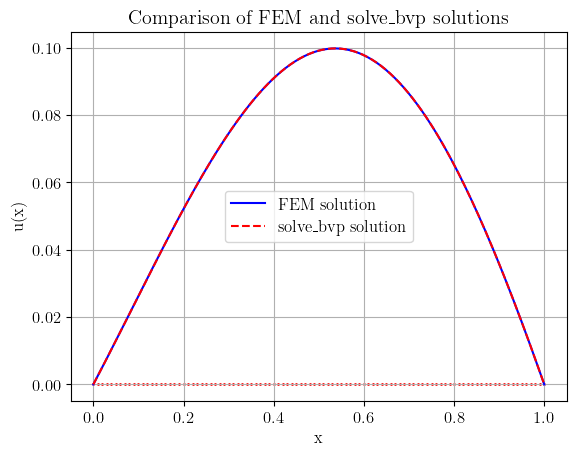

In [11]:
fem_solver = ConvectionDiffusionFEM(N=100, eps=1, beta=1, uniform=True)
fem_solver.compare_solution()

As this graph shows, both solutions agree significantly, achieving an $H^1$-error around $10^{-5}$.

## Results for different regimes
The behaviour of the solution is mainly determined by the Peclet number, defined as $\text{Pe} = \dfrac{\beta}{\epsilon}$ for a domain of length 1. A high Peclet number indicates a convection-dominated regime, where numerical instabilities are known to occur near the outflow boundary.

Our goal is to study whether a non-uniform mesh is better suited to overcoming the instabilities induced in high convection regimes.

### Uniform spacing, low Peclet number

L2-norm of the error: 6.299149308476238e-06
H1-norm of the error: 3.4035440287591733e-05


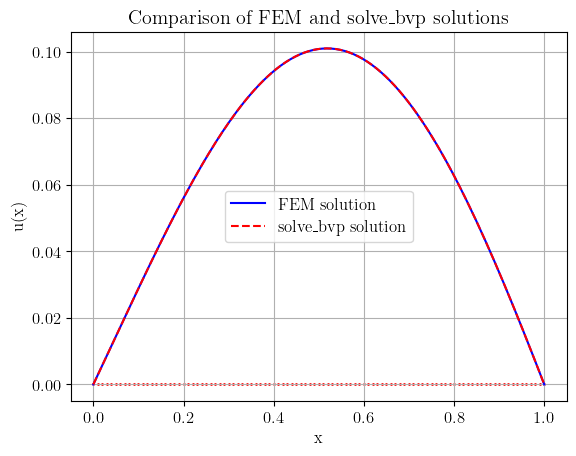

In [12]:
fem_solver = ConvectionDiffusionFEM(N=100, eps=1, beta=0.5, uniform=True)
fem_solver.compare_solution()

### Uniform spacing, high Peclet number (numerical instability expected)

L2-norm of the error: 0.0002334975159797893
H1-norm of the error: 0.032788352600250904


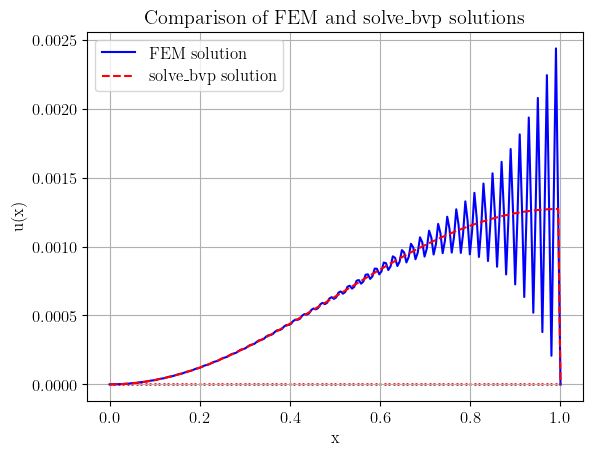

In [13]:
fem_solver = ConvectionDiffusionFEM(N=100, eps=0.1, beta=500, uniform=True)
fem_solver.compare_solution()

### Non-uniform spacing, low Peclet number

L2-norm of the error: 1.2681648807711423e-05
H1-norm of the error: 0.0009034046124810019


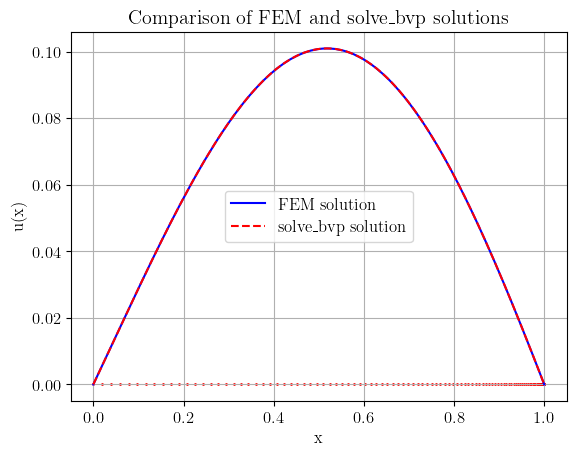

In [14]:
fem_solver = ConvectionDiffusionFEM(N=100, eps=1, beta=0.5, uniform=False)
fem_solver.compare_solution()

### Non-uniform spacing, high Peclet number

L2-norm of the error: 2.1542806447168997e-07
H1-norm of the error: 9.889571039524353e-06


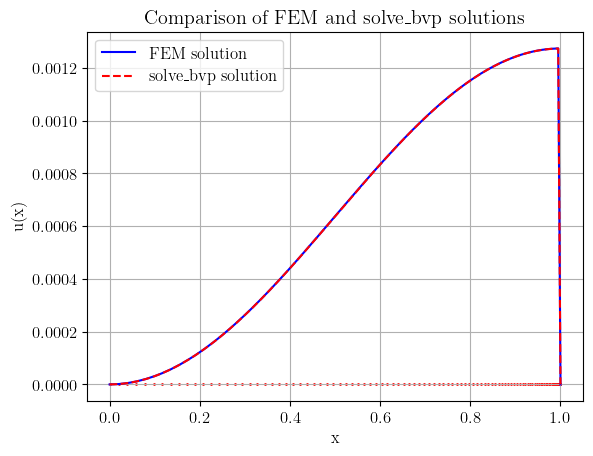

In [15]:
fem_solver = ConvectionDiffusionFEM(N=100, eps=0.1, beta=500, uniform=False)
fem_solver.compare_solution()

# Discussion
As a reminder, the $H^1$ norm of any vector is always larger than or equal to its $L_2$ norm.

For the low Peclet number regimes, where diffusion is somewhat significant, both the uniform and the non-uniform meshes had a remarkable performance. The $L_2$ norm of the error is of the order of $10^{-6}$ for both meshes, while the $H^1$ norm is near $10^{-4}$ for the non-uniform mesh and $10^{-6}$ for the uniform mesh.

It is natural for high-convection regimes to induce error propagation towards the $x=1$ boundary. As expected, using a non-uniform mesh quadratically clustered towards $x=1$ completely removes the numerical instability observed in the case of the uniform mesh. The $H^1$ error is similar for both meshes, despite the non-uniform one being evidently better. This similarity in the error is caused by the sharp edge near $x=1$. Firstly, the $H^1$ norm also accounts for errors in the gradient. Then, any small deviation from such a large gradient at the right boundary will be a significant addition to the error. The $L_2$ error seems to be more informative, given that it is much lower in the non-uniform mesh and does not account for the gradient errors.

# Error analysis
We can confirm the theoretical predictions of the error size in terms of the element size. The $L_2$ error is expected to depend on $h^2$, while the $H^1$ error depends on $h$ theoretically. We can confirm these dependencies by running our implementation for different numbers of elements.

100%|█████████████████████████████████████████| 500/500 [04:39<00:00,  1.79it/s]


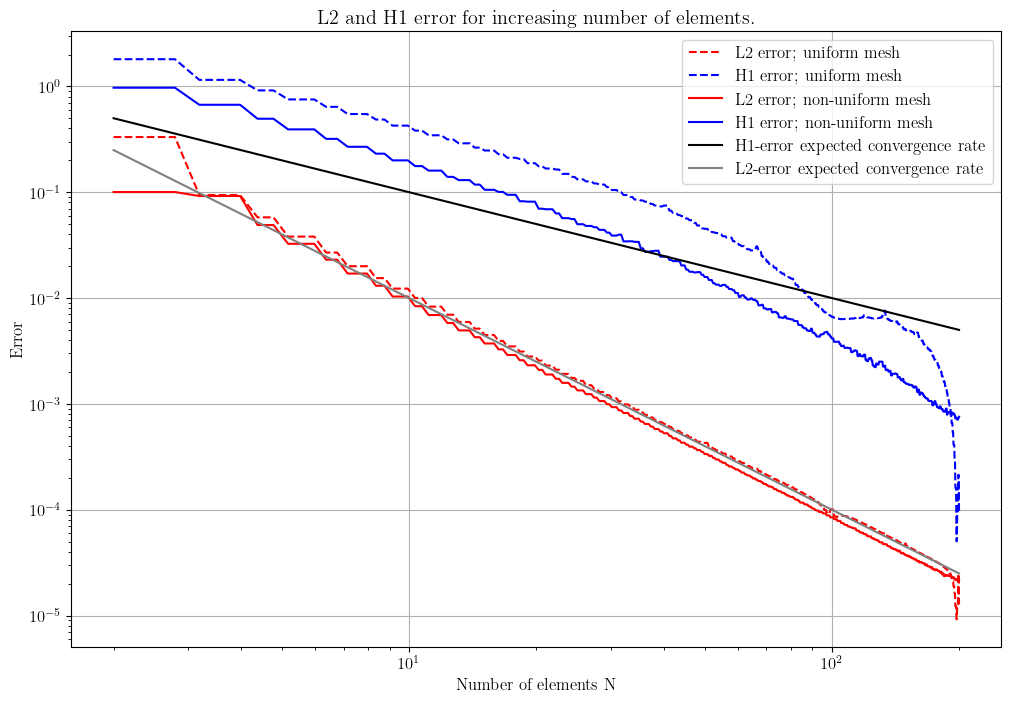

In [16]:
from tqdm import tqdm

def normed_error_analysis(bcs=(0, 0), bctype=(0, 0)):
    Ns = np.linspace(2, 200, 500)

    l2_errors_uniform = []
    h1_errors_uniform = []
    l2_errors_nonuniform = []
    h1_errors_nonuniform = []
    for N in tqdm(Ns):
        N = int(N)
        if bctype == (0, 0):
            fem_solver_uniform = ConvectionDiffusionFEM(N=N, eps=0.1, beta=1, uniform=True)
            l2, h1 = fem_solver_uniform.compare_solution(plot=False, error=True)
            l2_errors_uniform.append(l2)
            h1_errors_uniform.append(h1)
    
        fem_solver_nonuniform = ConvectionDiffusionFEM(N=N, eps=0.1, beta=1, uniform=False)
        l2, h1 = fem_solver_nonuniform.compare_solution(plot=False, error=True)
        l2_errors_nonuniform.append(l2)
        h1_errors_nonuniform.append(h1)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.plot(Ns, l2_errors_uniform, 'r--', label='L2 error; uniform mesh')
    ax.plot(Ns, h1_errors_uniform, 'b--', label='H1 error; uniform mesh')
    ax.plot(Ns, l2_errors_nonuniform, 'r-', label='L2 error; non-uniform mesh')
    ax.plot(Ns, h1_errors_nonuniform, 'b-', label='H1 error; non-uniform mesh')
    ax.plot(Ns, Ns ** (-1), 'k-', label='H1-error expected convergence rate')
    ax.plot(Ns, Ns ** (-2), '-', color='gray', label='L2-error expected convergence rate')
    ax.set_xlabel('Number of elements N')
    ax.set_ylabel('Error')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('L2 and H1 error for increasing number of elements.')
    ax.grid(True)
    ax.legend()
    plt.show()


normed_error_analysis()

As expected, the black line showing a relationship of $\text{error} \propto h \propto N^{-1}$ is parallel to the $H^1$ error, both for the uniform and non-uniform meshes. For large values of $N$, this convergence rate seems to decrease, as the slope increases.

The gray line showing $\text{error} \propto h^2 \propto N^{-2}$ is parallel to the $L^2$ errors of the uniform and non-uniform meshes, as expected.

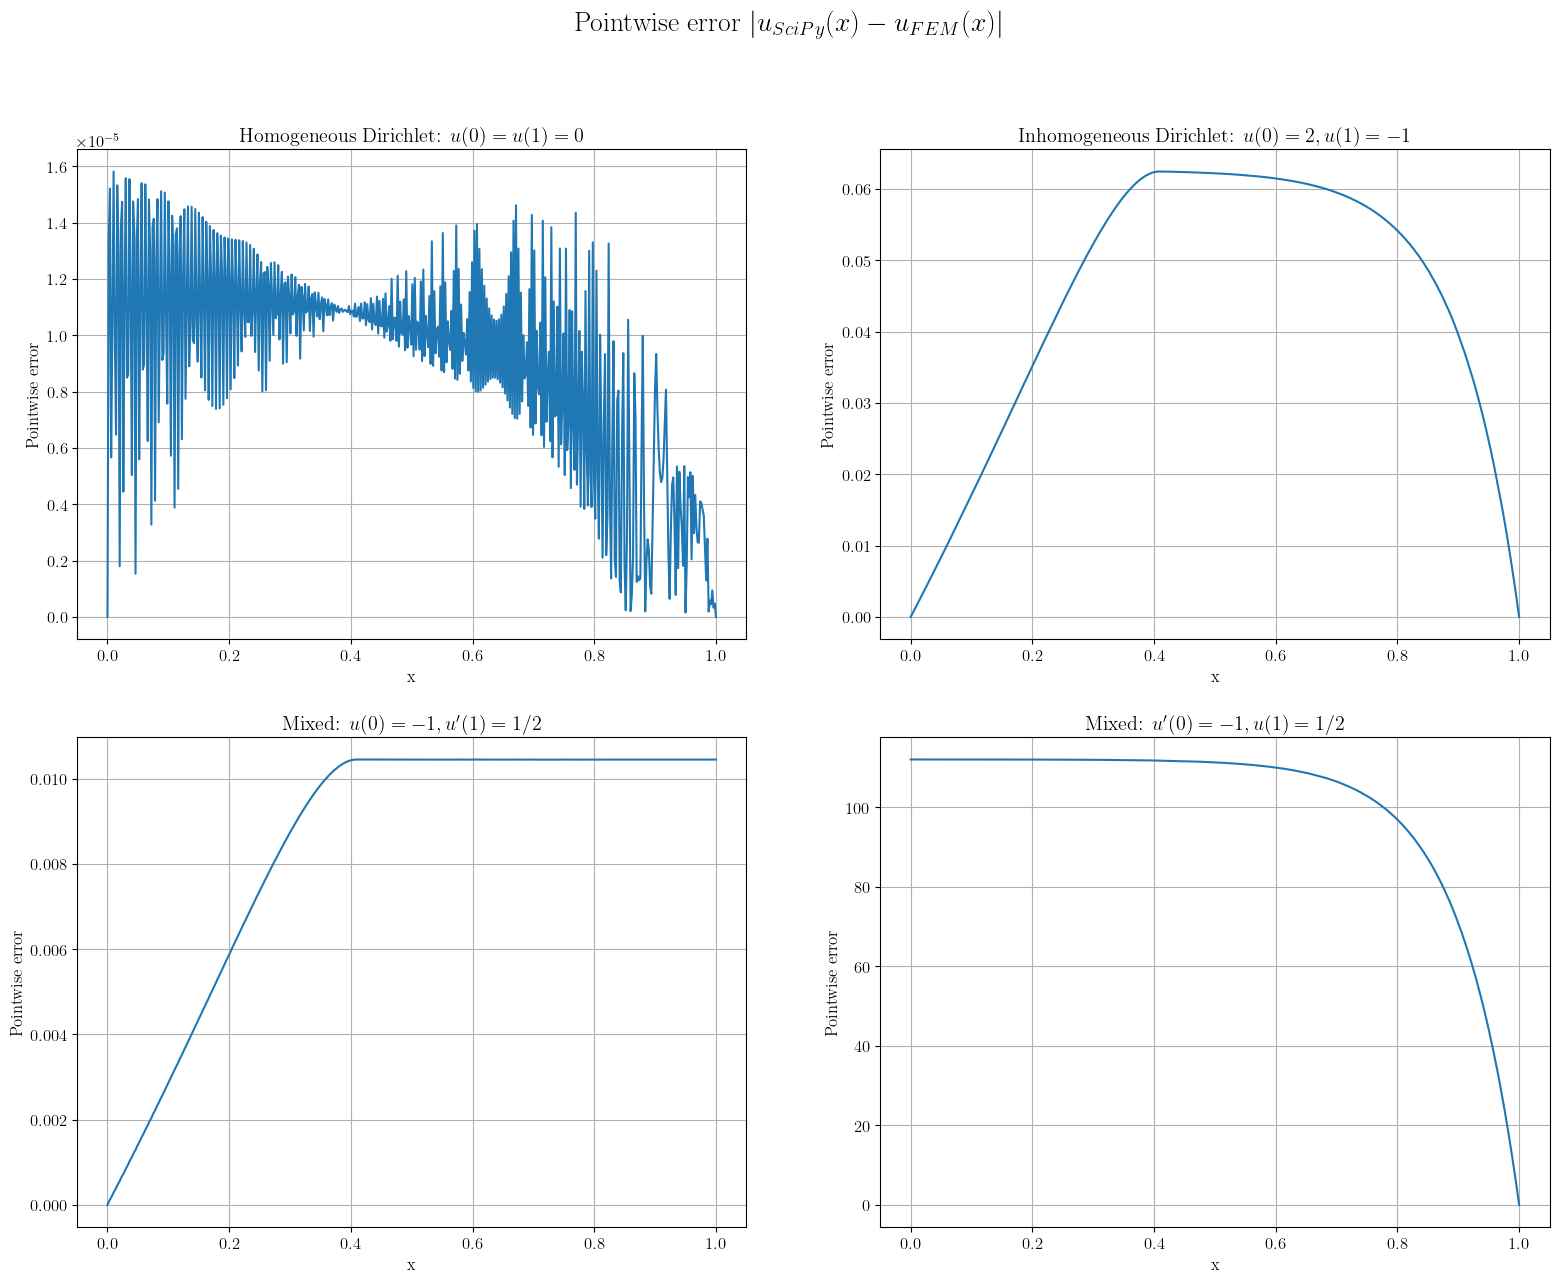

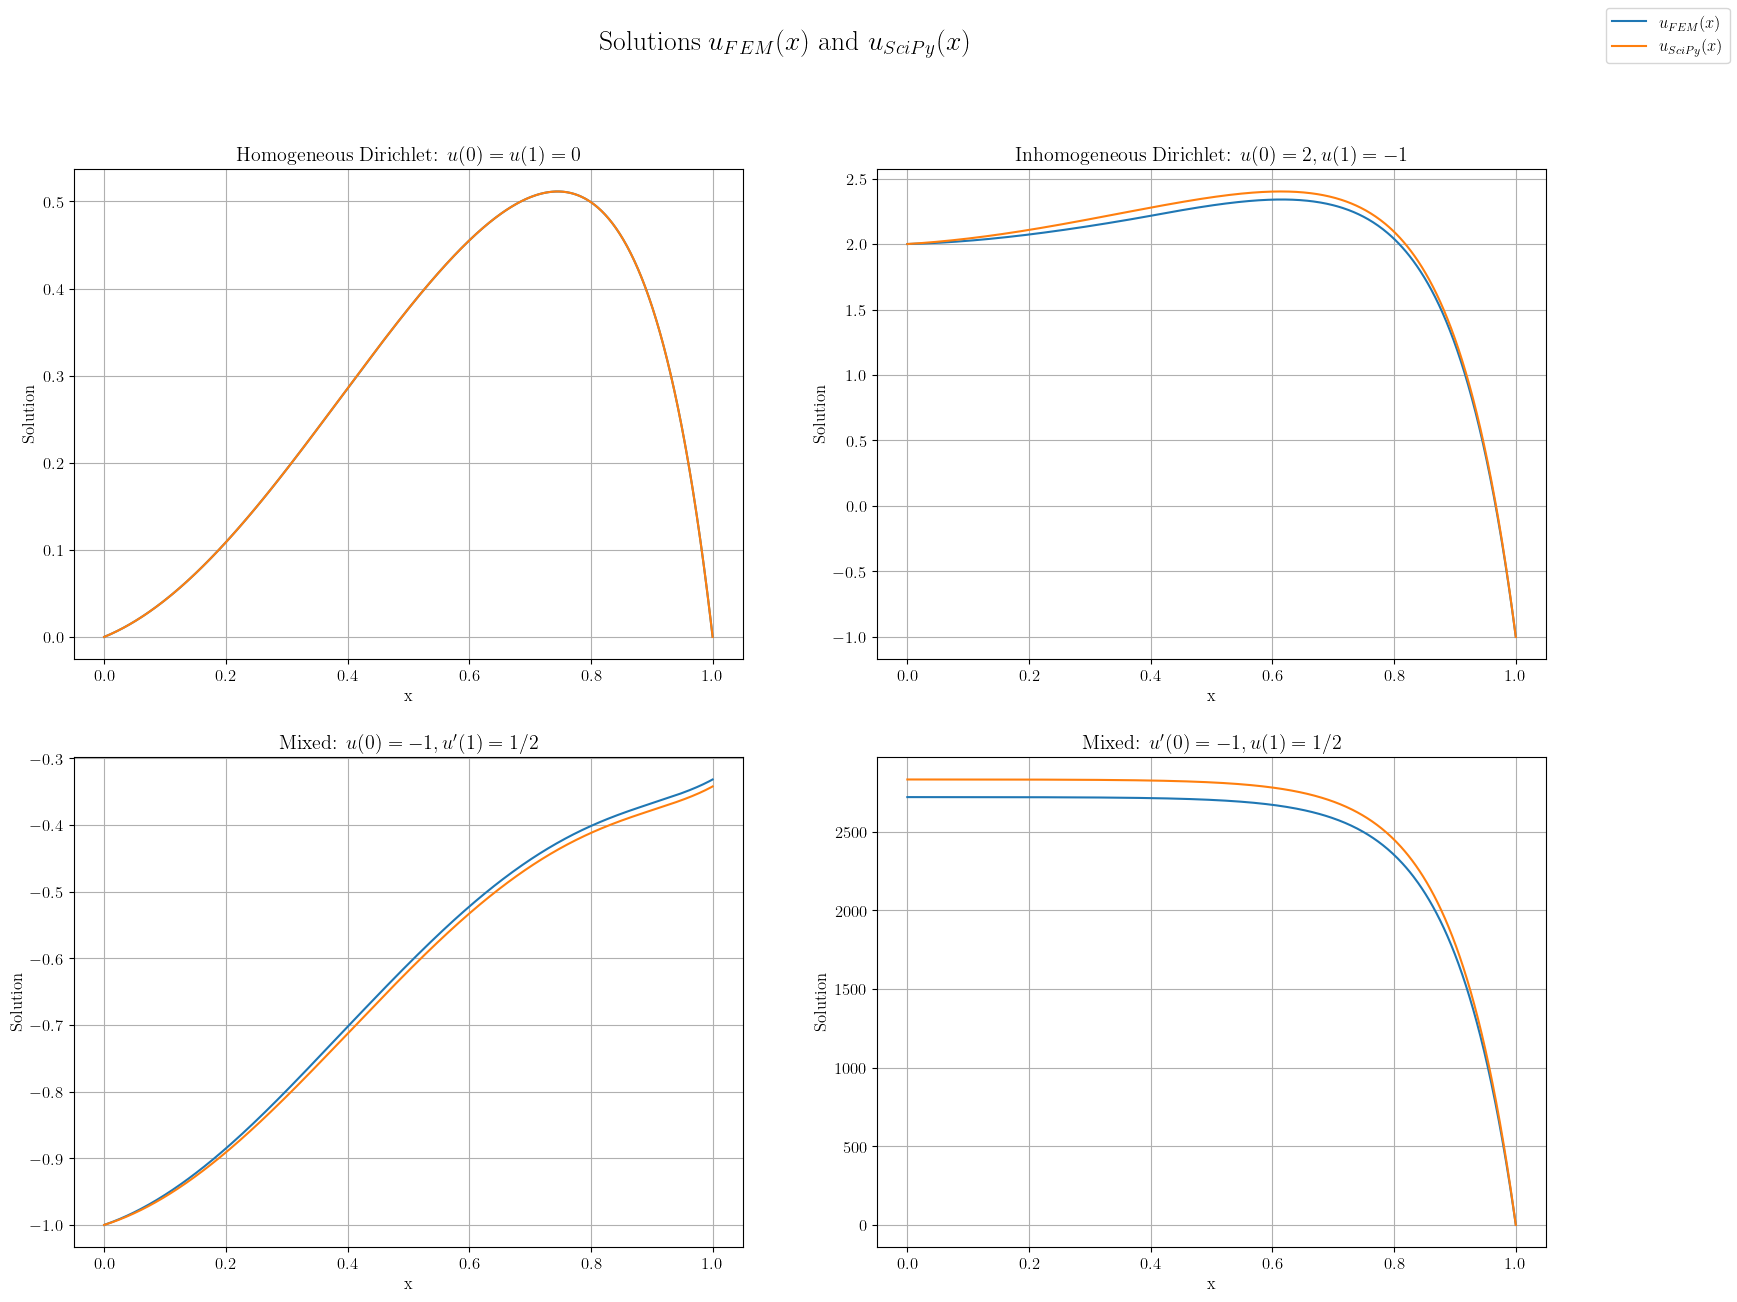

In [17]:
def pointwise_error(N=300, N_eval=500):
    x_eval = np.linspace(0, 1, N_eval)
    
    bctypes = [(0, 0), (0, 0), (0, 1), (1, 0)]
    bcss = [(0, 0),     # Homogeneous Dirichlet
            (2, -1),    # Inhomogeneous Dirichlet
            (-1, 1/2),  # Mixed: Dirichlet at the left boundary, Neumann at the right
            (-1, 1/2)]  # Mixed: Neumann at the left boundary, Dirichlet at the right

    errors = []
    u_fems = []
    u_bvps = []
    for bctype, bcs in zip(bctypes, bcss):
        solver = ConvectionDiffusionFEM(N=N, eps=0.1, beta=1, uniform=False, bctype=bctype, bcs=bcs)
        u_fem = solver.solve_fem(x_eval)
        u_bvp = solver.solve_scipy(x_eval)

        pointwise_error = np.abs(u_fem - u_bvp)
        errors.append(pointwise_error)
        u_fems.append(u_fem)
        u_bvps.append(u_bvp)


    fig1, ((ax10, ax11), (ax12, ax13)) = plt.subplots(2, 2, figsize=(19, 14))
    ax10.plot(x_eval, errors[0])
    ax11.plot(x_eval, errors[1])
    ax12.plot(x_eval, errors[2])
    ax13.plot(x_eval, errors[3])

    fig1.suptitle(r'Pointwise error $|u_{SciPy}(x) - u_{FEM}(x)|$', fontsize=20)
    
    ax10.set_xlabel(r'x')
    ax10.set_ylabel(r'Pointwise error')
    ax10.set_title(r'Homogeneous Dirichlet: $u(0)=u(1)=0$')
    ax10.grid(True)

    ax11.set_xlabel(r'x')
    ax11.set_ylabel(r'Pointwise error')
    ax11.set_title(r'Inhomogeneous Dirichlet: $u(0) = 2, u(1) = -1$')
    ax11.grid(True)

    ax12.set_xlabel(r'x')
    ax12.set_ylabel(r'Pointwise error')
    ax12.set_title(r'Mixed: $u(0) = -1, u^\prime(1) = 1/2$')
    ax12.grid(True)

    ax13.set_xlabel(r'x')
    ax13.set_ylabel(r'Pointwise error')
    ax13.set_title(r'Mixed: $u^\prime(0) = -1, u(1) = 1/2$')
    ax13.grid(True)

    fig2, ((ax20, ax21), (ax22, ax23)) = plt.subplots(2, 2, figsize=(19, 14))
    
    ax20.plot(x_eval, u_fems[0], color='#1f77b4')
    ax20.plot(x_eval, u_bvps[0], color='#ff7f0e')
    ax20.plot([], [], label=r'$u_{FEM}(x)$', color='#1f77b4')
    ax20.plot([], [], label=r'$u_{SciPy}(x)$', color='#ff7f0e')
    
    ax21.plot(x_eval, u_fems[1], color='#1f77b4')
    ax21.plot(x_eval, u_bvps[1], color='#ff7f0e')
    
    ax22.plot(x_eval, u_fems[2], color='#1f77b4')
    ax22.plot(x_eval, u_bvps[2], color='#ff7f0e')
    
    ax23.plot(x_eval, u_fems[3], color='#1f77b4')
    ax23.plot(x_eval, u_bvps[3], color='#ff7f0e')

    fig2.suptitle(r'Solutions $u_{FEM}(x)$ and $u_{SciPy}(x)$', fontsize=20)
    fig2.legend()
    
    ax20.set_xlabel(r'x')
    ax20.set_ylabel(r'Solution')
    ax20.set_title(r'Homogeneous Dirichlet: $u(0)=u(1)=0$')
    ax20.grid(True)

    ax21.set_xlabel(r'x')
    ax21.set_ylabel(r'Solution')
    ax21.set_title(r'Inhomogeneous Dirichlet: $u(0) = 2, u(1) = -1$')
    ax21.grid(True)

    ax22.set_xlabel(r'x')
    ax22.set_ylabel(r'Solution')
    ax22.set_title(r'Mixed: $u(0) = -1, u^\prime(1) = 1/2$')
    ax22.grid(True)

    ax23.set_xlabel(r'x')
    ax23.set_ylabel(r'Solution')
    ax23.set_title(r'Mixed: $u^\prime(0) = -1, u(1) = 1/2$')
    ax23.grid(True)
    
    plt.show()
        

pointwise_error()